In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

In [2]:
# set variables
use_seed = False
threshold = 1 # possible values are: 1, 2, 5, 10
epochs = 300 # set the number of epochs you want to train the network (default = 300)
save_fig = False # set True to save the plots

In [3]:
if save_fig:
    path = '../plots'
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)

In [4]:
if torch.cuda.device_count()>1:
    torch.cuda.empty_cache()

    gpu_sel = 1
    gpu_av = [torch.cuda.is_available() for ii in range(torch.cuda.device_count())]
    print("Detected {} GPUs. The load will be shared.".format(torch.cuda.device_count()))
    for gpu in range(len(gpu_av)):
        if True in gpu_av:
            if gpu_av[gpu_sel]:
                device = torch.device("cuda:"+str(gpu))
                torch.cuda.set_per_process_memory_fraction(0.5, device=device)
                print("Selected GPUs: {}" .format("cuda:"+str(gpu)))
            else:
                device = torch.device("cuda:"+str(gpu_av.index(True)))
        else:
            device = torch.device("cpu")
            print("No GPU detected. Running on CPU.")
else:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

        print("Single GPU detected. Setting up the simulation there.")
        device = torch.device("cuda:0")
        torch.cuda.set_per_process_memory_fraction(0.5, device=device)
    else:
        device = torch.device("cpu")
        print("No GPU detected. Running on CPU.")


Detected 2 GPUs. The load will be shared.
Selected GPUs: cuda:0
Selected GPUs: cuda:1


In [5]:
if use_seed:
    seed = 42
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Seed set to {}".format(seed))
else:
    print("Shuffle data randomly")

Seed set to 42


In [6]:
dtype = torch.float

In [7]:
letters = ['Space', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [8]:
def load_and_extract(params, file_name, taxels=None, letter_written=letters):
    
    max_time = int(54*25) # ms
    time_bin_size = int(params['time_bin_size']) # ms
    global time
    time = range(0,max_time,time_bin_size)
    
    global time_step
    time_step = time_bin_size*0.001
    data_steps = len(time)
    
    infile = open(file_name, 'rb')
    data_dict = pickle.load(infile)
    infile.close()

    # Extract data
    data = []
    labels = []
    bins = 1000 # ms conversion
    nchan = len(data_dict[1]['events']) # number of channels per sensor
    for i, sample in enumerate(data_dict):
        dat = (sample['events'][:])
        events_array = np.zeros([nchan,round((max_time/time_bin_size)+0.5),2])
        for taxel in range(len(dat)):
            for event_type in range(len(dat[taxel])):
                if dat[taxel][event_type]:
                    indx = bins*(np.array(dat[taxel][event_type]))
                    indx = np.array((indx/time_bin_size).round(), dtype=int)
                    events_array[taxel,indx,event_type] = 1
        if taxels != None:
            events_array = np.reshape(np.transpose(events_array, (1,0,2))[:,taxels,:],(events_array.shape[1],-1))
            selected_chans = 2*len(taxels)
        else:
            events_array = np.reshape(np.transpose(events_array, (1,0,2)),(events_array.shape[1],-1))
            selected_chans = 2*nchan
        data.append(events_array)
        labels.append(letter_written.index(sample['letter']))
        
    # return data,labels
    data = np.array(data)
    labels = np.array(labels)

    data = torch.tensor(data, dtype=dtype )    
    labels = torch.tensor(labels,dtype=torch.long)

    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, shuffle=True, stratify=labels)

    ds_train = TensorDataset(x_train,y_train)
    ds_test = TensorDataset(x_test,y_test)
    
    return ds_train, ds_test, labels, selected_chans, data_steps

In [9]:
def run_snn(inputs, layers):

    bs = inputs.shape[0]
    h1_from_input = torch.einsum("abc,cd->abd", (inputs.tile((nb_input_copies,)), layers[0]))
    syn = torch.zeros((bs,nb_hidden_1), device=device, dtype=dtype)
    mem = torch.zeros((bs,nb_hidden_1), device=device, dtype=dtype)

    out = torch.zeros((bs, nb_hidden_1), device=device, dtype=dtype)

    # Here we define two lists which we use to record the membrane potentials and output spikes
    mem_rec = []
    spk_rec = []

    # Compute first hidden layer activity
    for t in range(nb_steps):
        h1 = h1_from_input[:,t]
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn + h1
        new_mem = (beta*mem + syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
    
        mem = new_mem
        syn = new_syn

    # Now we merge the recorded membrane potentials into a single tensor
    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # second hidden layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, layers[1]))
    syn2 = torch.zeros((bs,nb_hidden_2), device=device, dtype=dtype)
    mem2 = torch.zeros((bs,nb_hidden_2), device=device, dtype=dtype)
    out2 = torch.zeros((bs, nb_hidden_2), device=device, dtype=dtype)

    # Here we define two lists which we use to record the membrane potentials and output spikes
    mem_rec2 = []
    spk_rec2 = []
    # Compute second hidden layer activity
    for t in range(nb_steps):
        mthr2 = mem2-1.0
        out2 = spike_fn(mthr2)
        rst2 = out2.detach() # We do not want to backprop through the reset

        new_syn2 = alpha*syn2 + h2[:,t]
        new_mem2 = (beta*mem2 + syn2)*(1.0-rst2)

        mem_rec2.append(mem2)
        spk_rec2.append(out2)
    
        mem2 = new_mem2
        syn2 = new_syn2

    # Now we merge the recorded membrane potentials into a single tensor
    mem_rec2 = torch.stack(mem_rec2,dim=1)
    spk_rec2 = torch.stack(spk_rec2,dim=1)

    # Readout layer
    h3 = torch.einsum("abc,cd->abd", (spk_rec2, layers[2]))
    flt = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((bs,nb_outputs), device=device, dtype=dtype)
    s_out_rec = [out] # out is initialized as zeros, so it is fine to start with this
    out_rec = [out]
    for t in range(nb_steps):
        mthr_out = out-1.0
        s_out = spike_fn(mthr_out)
        rst_out = s_out.detach()

        new_flt = alpha*flt + h3[:,t]
        new_out = (beta*out + flt)*(1.0-rst_out)

        flt = new_flt
        out = new_out

        out_rec.append(out)
        s_out_rec.append(s_out)

    out_rec = torch.stack(out_rec,dim=1)
    s_out_rec = torch.stack(s_out_rec,dim=1)
    other_recs = [mem_rec, spk_rec, mem_rec2, spk_rec2, s_out_rec]
    layers_update = layers

    
    return out_rec, other_recs, layers_update

In [10]:
def load_layers(file, map_location, requires_grad=True, variable=False):
    
    if variable:
        
        lays = file
        
        for ii in lays:
            ii.requires_grad = requires_grad
    
    else:
        
        lays = torch.load(file, map_location=map_location)
    
        for ii in lays:
            ii.requires_grad = requires_grad
        
    return lays

In [11]:
def build_and_predict(params, x, use_nni_weights):
    
    x = x.to(device)
    
    global nb_input_copies
    nb_input_copies = params['nb_input_copies']  # Num of spiking neurons used to encode each channel 

    # Network parameters
    global nb_inputs
    nb_inputs  = nb_channels*nb_input_copies
    global nb_hidden_1
    nb_hidden_1  = 200
    global nb_hidden_2
    nb_hidden_2  = 300
    global nb_outputs
    nb_outputs = len(np.unique(labels))+1
    global nb_steps
    nb_steps = data_steps

    tau_mem = params['tau_mem'] # ms
    tau_syn = tau_mem/params['tau_ratio']
    
    global alpha
    alpha   = float(np.exp(-time_step/tau_syn))
    global beta
    beta    = float(np.exp(-time_step/tau_mem))

    fwd_weight_scale = params['fwd_weight_scale']
    
    # Spiking network
    if use_nni_weights:
        layers = load_layers('../NNI/SpyTorch_layers/best_test_'+file_type+'_thr_'+str(file_thr)+'_ref_'+str(file_ref)+'_'+optim_nni_experiment+'.pt', map_location=device)
    else:
        layers = []

        w1 = torch.empty((nb_inputs, nb_hidden_1),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w1, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_inputs))
        layers.append(w1)

        w2 = torch.empty((nb_hidden_1, nb_hidden_2),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w2, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_hidden_1))
        layers.append(w2)

        w3 = torch.empty((nb_hidden_2, nb_outputs), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w3, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_hidden_2))
        layers.append(w3)
    
    # Make predictions
    output, _, _ = run_snn(x,layers)
    m = torch.sum(others[-1],1) # sum over time
    _, am = torch.max(m, 1)     # argmax over output units
    
    return letters[am.detach().cpu().numpy()[0]]

In [12]:
def train(params, dataset, lr=0.0015, nb_epochs=300, opt_parameters=None, layers=None, dataset_test=None):
    
    ttc_hist = []
    
    if (opt_parameters != None) & (layers != None):
        parameters = opt_parameters # The paramters we want to optimize
        layers = layers
    elif (opt_parameters != None) & (layers == None): 
        parameters = opt_parameters
        layers = [w1, w2, w3]
    elif (opt_parameters == None) & (layers != None):
        parameters = [w1, w2, w3]
        layers = layers
    elif (opt_parameters == None) & (layers == None):
        parameters = [w1, w2, w3]
        layers = [w1, w2, w3]
        
    optimizer = torch.optim.Adamax(parameters, lr=0.0015, betas=(0.9,0.995))

    log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
    loss_fn = nn.NLLLoss() # The negative log likelihood loss function

    generator = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2) # batch_size=128

    # The optimization loop
    loss_hist = []
    accs_hist = [[],[]]
    for e in range(nb_epochs):
        local_loss = []
        # accs: mean training accuracies for each batch
        accs = []
        for x_local, y_local in generator:
            x_local, y_local = x_local.to(device), y_local.to(device)
            output,recs,layers_update = run_snn(x_local,layers)
            _,spks,_,_,_=recs # [mem_rec, spk_rec, mem_rec2, spk_rec2, s_out_rec]
            # with output spikes
            m = torch.sum(recs[-1],1) # sum over time
            log_p_y = log_softmax_fn(m)
        
            # Here we can set up our regularizer loss
            reg_loss = params['reg_spikes']*torch.mean(torch.sum(spks,1)) # e.g., L1 loss on total number of spikes (original: 1e-3)
            reg_loss += params['reg_neurons']*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron (original: 2e-6)
        
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        
            # compare to labels
            _, am = torch.max(m, 1) # argmax over output units
            tmp = np.mean((y_local == am).detach().cpu().numpy())
            accs.append(tmp)
    
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        
        # mean_accs: mean training accuracy of current epoch (average over all batches)
        mean_accs = np.mean(accs)
        accs_hist[0].append(mean_accs)

        # Calculate test accuracy in each epoch
        if dataset_test is not None:
            test_acc, test_ttc = compute_classification_accuracy(
                params,
                dataset_test,
                layers=layers_update,
                early=True
            )
            accs_hist[1].append(test_acc) # only safe best test
            ttc_hist.append(test_ttc)
        
        if dataset_test is None:
            # save best training
            if mean_accs >= np.max(accs_hist[0]):
                best_acc_layers = []
                for ii in layers_update:
                    best_acc_layers.append(ii.detach().clone())
        else:
            # save best test
            if np.max(test_acc) >= np.max(accs_hist[1]):
                best_acc_layers = []
                for ii in layers_update:
                    best_acc_layers.append(ii.detach().clone())
        
        print("Epoch {}/{} done. Train accuracy: {:.2f}%, Test accuracy: {:.2f}%.".format(e+1,nb_epochs, accs_hist[0][-1]*100, accs_hist[1][-1]*100))
    

    return loss_hist, accs_hist, best_acc_layers, ttc_hist

In [13]:
def build_and_train(params, ds_train, ds_test, epochs=epochs):
    
    global nb_input_copies
    nb_input_copies = params['nb_input_copies']  # Num of spiking neurons used to encode each channel 

    # Network parameters
    global nb_inputs
    nb_inputs  = nb_channels*nb_input_copies
    global nb_hidden_1
    nb_hidden_1  = 200
    global nb_hidden_2
    nb_hidden_2  = 300
    global nb_outputs
    nb_outputs = len(np.unique(labels))+1
    global nb_steps
    nb_steps = data_steps

    tau_mem = params['tau_mem'] # ms
    tau_syn = tau_mem/params['tau_ratio']
    
    global alpha
    alpha   = float(np.exp(-time_step/tau_syn))
    global beta
    beta    = float(np.exp(-time_step/tau_mem))

    fwd_weight_scale = params['fwd_weight_scale']

    # Spiking network
    layers = []
    w1 = torch.empty((nb_inputs, nb_hidden_1),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w1, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_inputs))
    layers.append(w1)

    w2 = torch.empty((nb_hidden_1, nb_hidden_2),  device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w2, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_hidden_1))
    layers.append(w2)

    w3 = torch.empty((nb_hidden_2, nb_outputs), device=device, dtype=dtype, requires_grad=True)
    torch.nn.init.normal_(w3, mean=0.0, std=fwd_weight_scale/np.sqrt(nb_hidden_2))
    layers.append(w3)

    layers_init = []
    for ii in layers:
        layers_init.append(ii.detach().clone())

    opt_parameters = [w1, w2, w3]
    
    # a fixed learning rate is already defined within the train function, that's why here it is omitted
    loss_hist, accs_hist, best_layers, _ = train(params, ds_train, nb_epochs=epochs, opt_parameters=opt_parameters, layers=layers, dataset_test=ds_test)

    # best training and test at best training
    acc_best_train = np.max(accs_hist[0]) # returns max value
    acc_best_train = acc_best_train*100
    idx_best_train = np.argmax(accs_hist[0]) # returns index of max value 
    acc_test_at_best_train = accs_hist[1][idx_best_train]*100

    # best test and training at best test
    acc_best_test = np.max(accs_hist[1])
    acc_best_test = acc_best_test*100
    idx_best_test = np.argmax(accs_hist[1])
    acc_train_at_best_test = accs_hist[0][idx_best_test]*100

    print("Final results: \n")
    print("Best training accuracy: {:.2f}% and according test accuracy: {:.2f}% at epoch: {}".format(acc_best_train, acc_test_at_best_train, idx_best_train+1)) # only from training
    print("Best test accuracy: {:.2f}% and according train accuracy: {:.2f}% at epoch: {}".format(acc_best_test, acc_train_at_best_test, idx_best_test+1)) # only from training

    return loss_hist, accs_hist, best_layers

In [14]:
def compute_classification_accuracy(params, dataset, layers=None, early=False):
    """ Computes classification accuracy on supplied data in batches. """

    generator = DataLoader(dataset, batch_size=128,
                           shuffle=False, num_workers=2)
    accs = []
    multi_accs = []
    ttc = None

    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        if layers == None:
            layers = [w1, w2, w3]
            output, others, _= run_snn(x_local,layers)
        else:
            output, others, _ = run_snn(x_local,layers)

        m = torch.sum(others[-1],1) # sum over time
        _, am = torch.max(m, 1)     # argmax over output units
        # compare to labels
        tmp = np.mean((y_local == am).detach().cpu().numpy())
        accs.append(tmp)

        if early:
            accs_early = []
            for t in range(output.shape[1]-1):
                m_early = torch.sum(others[-1][:,:t+1,:],1) # sum over time
                _, am_early = torch.max(m_early, 1)         # argmax over output units
                # compare to labels
                tmp_early = np.mean((y_local == am_early).detach().cpu().numpy())
                accs_early.append(tmp_early)
            multi_accs.append(accs_early)
    
    if early:
        mean_multi = np.mean(multi_accs, axis=0)
        if np.max(mean_multi) > mean_multi[-1]:
            if mean_multi[-2]==mean_multi[-1]:
                flattening = []
                for ii in range(len(mean_multi)-2,1,-1):
                    if mean_multi[ii] != mean_multi[ii-1]:
                        flattening.append(ii)
                # time to classify
                ttc = time[flattening[0]]
            else:
                # time to classify
                ttc = time[-1]
        else:
            # time to classify
            ttc = time[np.argmax(mean_multi)]

    return np.mean(accs), ttc

In [15]:
def ConfusionMatrix(dataset, save, layers=None, labels=letters):
    
    generator = DataLoader(dataset, batch_size=128,
                           shuffle=False, num_workers=2)
    accs = []
    trues = []
    preds = []
    for x_local, y_local in generator:
        x_local, y_local = x_local.to(device), y_local.to(device)
        if layers == None:
            layers = [w1, w2, w3]
            output, others, _= run_snn(x_local, layers)
        else:
            output, others, _= run_snn(x_local, layers)

        m = torch.sum(others[-1],1) # sum over time
        _, am = torch.max(m, 1)     # argmax over output units
        # compare to labels
        tmp = np.mean((y_local == am).detach().cpu().numpy())
        accs.append(tmp)
        trues.extend(y_local.detach().cpu().numpy())
        preds.extend(am.detach().cpu().numpy())

    cm = confusion_matrix(trues, preds, normalize='true')
    cm_df = pd.DataFrame(cm, index=[ii for ii in labels], columns=[jj for jj in labels])
    plt.figure(figsize=(12,9))
    sn.heatmap(cm_df,
               annot=True,
               fmt='.1g',
               cbar=False,
               square=False,
               cmap="YlGnBu")
    plt.xlabel('\nPredicted')
    plt.ylabel('True\n')
    plt.xticks(rotation=0)
    if save:
        plt.savefig("../plots/ffsnn_thr_" + str(threshold) + "_cm.png")
    plt.show()

Load braille data

In [16]:
file_dir_data = '../data/'
file_type = 'data_braille_letters_th'
file_thr = str(threshold)
file_name = file_dir_data + file_type + file_thr

file_dir_params = '../parameters/'
param_filename = 'parameters_th' + str(threshold)  + '.txt'
file_name_parameters = file_dir_params + param_filename
params = {}
with open(file_name_parameters) as file:
 for line in file:
    (key, value) = line.split()
    if key == 'time_bin_size' or key == 'nb_input_copies':
        params[key] = int(value)
    else:
        params[key] = np.double(value)


In [17]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """

    scale = params['scale']

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

spike_fn  = SurrGradSpike.apply

### Train and test the network

In [18]:
ds_train, ds_test, labels, nb_channels, data_steps = load_and_extract(params, file_name, letter_written=letters)

loss_hist, acc_hist, best_layers = build_and_train(params, ds_train, ds_test, epochs=epochs)

Epoch 1/2 done. Train accuracy: 9.33%, Test accuracy: 13.33%.
Epoch 2/2 done. Train accuracy: 18.96%, Test accuracy: 25.11%.
Final results: 

Best training accuracy: 18.96% and according test accuracy: 25.11% at epoch: 2
Best test accuracy: 25.11% and according train accuracy: 18.96% at epoch: 2


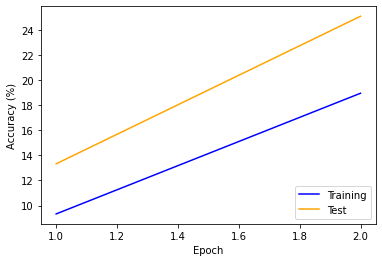

In [19]:
plt.figure()
plt.plot(range(1,len(acc_hist[0])+1),100*np.array(acc_hist[0]), color='blue')
plt.plot(range(1,len(acc_hist[1])+1),100*np.array(acc_hist[1]), color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend(["Training","Test"], loc='lower right')
if save_fig:
    plt.savefig("../plots/ffsnn_thr_"+str(threshold)+"_acc.png")
plt.show()

### Confusion matrix

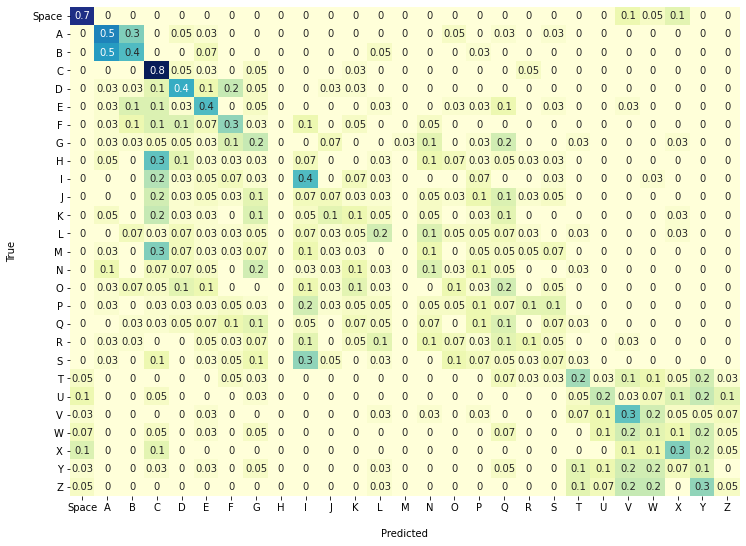

In [20]:
ConfusionMatrix(ds_test, layers=best_layers, save=save_fig)